In [1]:
![ ! -e Code ]  && ln -s .. Code

In [2]:
from Code.gram import GRAM_RTM

In [3]:
act_map_dataset = GRAM_RTM(prefix="GRAM")

In [4]:
import torch.nn as nn
import detectron2 as dt
from detectron2.config import get_cfg
from detectron2 import model_zoo as zoo
from detectron2.engine import DefaultPredictor

class AdaptedFasterRCNN(nn.Module):

    def __init__(self):
        super(AdaptedFasterRCNN, self).__init__()
        cfg = get_cfg()
        cfg.merge_from_file(zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
        cfg.MODEL.WEIGHTS = zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
        predictor = DefaultPredictor(cfg)
        self.backbone = predictor.model.backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.conv1 = nn.Conv2d(1024, 1, 1)
#         self.conv2 = nn.Conv2d(128, 64, 5)
        self.linear = nn.Linear(1 * 3 * 6, 7)
        self.relu = nn.ReLU()
#         self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(4)
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self, images):
        '''
        Run mini-batch of images through model.

        Args:
            images (Tensor): A tensor of size (N, C, H, W) where
                N is the batch size
                C is the number of channels
                H is the image height
                W is the image width

        Returns:
            A Tensor of size (N, num_labels) specifying the score
            for each example and a certain number of cars.
        '''
        N = images.shape[0]
        activation_map = self.backbone(images)['res4']
#         print(activation_map.shape)
        activation_map = self.maxpool2(self.relu(self.conv1(activation_map)))
#         print(activation_map.shape)
        scores = self.linear(activation_map.view(N, -1))
        return scores
#         return self.softmax(scores)

In [5]:
import torch
sample = act_map_dataset[0]
print(sample[0].shape)
rcnn = AdaptedFasterRCNN().cuda()
input_tensor = sample[0].unsqueeze(0).cuda()
rcnn(input_tensor)

torch.Size([3, 224, 373])


tensor([[-1.3639, -0.9761,  0.6508,  0.2747, -0.0389,  0.5174,  0.5805]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [6]:
from torch.utils.data import DataLoader
train_dataset = GRAM_RTM(prefix="GRAM", split="train")
val_dataset = GRAM_RTM(prefix="GRAM", split="val")
test_dataset = GRAM_RTM(prefix="GRAM", split="test")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
import torch.nn.functional as F
import torch.optim as optim

sgd = optim.SGD(rcnn.parameters(), lr=0.01, momentum=0.9)
criterion = F.cross_entropy

def train(epoch, losses):
    '''
    Train the model for one epoch.
    '''
    for batch_idx, batch in enumerate(train_loader):
        act_maps, targets = batch[0].cuda(), batch[1].cuda()
        sgd.zero_grad()
        output = rcnn(act_maps)
        loss = criterion(output, targets)
        np_output = output[0].detach().cpu().numpy()
        print(f'\r{epoch}: {loss.item():.2f} {np_output} {np.argmax(np_output)} {targets[0].item()}\t', end='')
        losses.append(loss.item())
        loss.backward()
        sgd.step()
        
def evaluate(split):
    '''
    Compute loss on val or test data.
    '''
    loss = 0
    correct = 0
    n_examples = 0
    with torch.no_grad():
        if split == 'val':
            loader = val_loader
        elif split == 'test':
            loader = test_loader
        for batch_idx, batch in enumerate(loader):
            act_maps, targets = batch[0].cuda(), batch[1].cuda()
            output = rcnn(act_maps)
            loss += criterion(output, targets).item()
            pred = torch.argmax(output, dim=1)
            correct += (pred == targets).cpu().sum().item()
            n_examples += pred.shape[0]
        loss /= n_examples
        acc = 100. * correct / n_examples
        if verbose:
            print(f'{split} set: Average loss: {loss:.4f}, Accuracy: {correct}/{n_examples} ({acc:.0f}%)')
    return loss, acc

In [8]:
output = torch.tensor([[1, 0, 0], [1, 0, 0], [0, 0, 1]])
labels = torch.tensor([1, 0, 2])
torch.sum(torch.argmax(output, dim=1) == labels)
output.shape[0]

3

In [9]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

losses = []
for i in range(10):
    train(i, losses)

9: 1.72 [-0.558 0.896 1.498 0.831 0.471 -0.789 -2.276] 2 2	

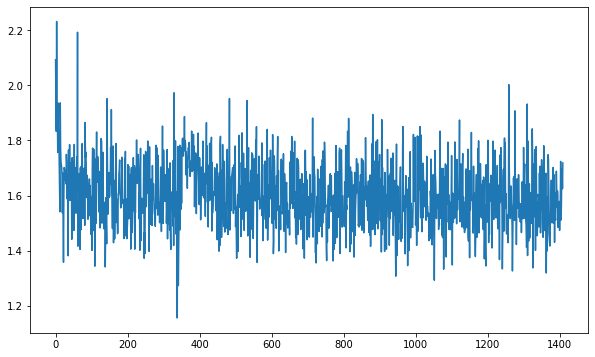

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(losses)